In [23]:
import logging, sys
logging.disable(sys.maxsize)
import pymongo
import pandas as pd
import statistics_utility as su
from web3 import Web3
import matplotlib
matplotlib.use('nbagg')
from evaluation.wallet_constant import BURNING_ADDRESSES
from evaluation.wallet_constant import LIQUIDITY_LOCKERS
from evaluation.evaluator import Evaluator
import evaluation.evaluation_config
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np


plt.rcParams['figure.dpi'] = 200

db_client = pymongo.MongoClient("mongodb://localhost:27017/")
scam_db = db_client["eth-scam-checker"]

#statistics_db = db_client['statistics']
#statistics_rescan_db = db_client['statistics-rescan']
# statistics_db = db_client['statistics-big-legit-dataset']
# statistics_rescan_db = db_client['statistics-big-legit-dataset-rescan']
# statistics_db = db_client['statistics-big-dataset']
# statistics_rescan_db = db_client['statistics-big-dataset-rescan']


# big_dataset_db = db_client['statistics-big-dataset']
# big_dataset_rescan_db = db_client['statistics-big-dataset-rescan']

big_dataset_50_50_db = db_client['big-dataset-50-50']
big_dataset_50_50_rescan_db = db_client['big-dataset-50-50-rescan']

statistics_db = db_client['eth-scam-checker']
statistics_rescan_db = db_client['big-dataset-50-50-rescan']

testset_db = db_client['eth-scam-checker']
testset_rescan_db = db_client['testset-rescan-db']


# statistics_db = db_client['testset-db']
# statistics_rescan_db = db_client['testset-rescan-db']

logger = logging.getLogger(__name__)


# dataset_file = "./data/big_dataset_annotated_with_legit.csv"
# data = pd.read_csv(dataset_file)

#dataset_file = "./data/first_dataset.CSV"
#data = pd.read_csv(dataset_file)

# dataset_file = "./data/big_dataset_annotated.csv"
# data = pd.read_csv(dataset_file)

# dataset_file = "./data/big_dataset_annotated.csv"
# data = pd.read_csv(dataset_file)

# dataset_file = "./data/random_tokens_annotated.csv"
# data = pd.read_csv(dataset_file)

dataset_file = "./dataset/training_dataset.csv"
# dataset_file = "./data/big_dataset_current.csv"
data = pd.read_csv(dataset_file)


# dataset_testset_file = "./dataset/dataset_big.csv"
dataset_testset_file = "./dataset/TrainingDatasetNew.csv"
data_testset = pd.read_csv(dataset_testset_file)

# dataset_file = "./data/test_dataset.CSV"
# data = pd.read_csv(dataset_file)

    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
import joblib
%matplotlib notebook

trainset_numbers = []
trainset_scores = []
trainset_annotations = []

train_scam_data = []
train_benign_data = []

test_scam_data = []
test_benign_data = []

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        token = big_dataset_50_50_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
        if token is None:
            print(entry['address'])

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)
    result, final_result = evaluator.get_score()
    
#     if result['ownership_result'] == None:
#         result['ownership_result'] = 1.0
        
    local_features = [result['liquidity_share_result'], result['holder_share_result'], result['liquidity_amount_result'], 
                      result['honeypot_result'], result['ownership_result'], result['verified_contract_result'], 
                      result['vulnerabilities_result']]
    trainset_scores.append(local_features)    
    trainset_annotations.append(entry['scam'])


    #     print(result)
#     print(final_result)
#     print(entry['Scam'])
#     trainset_scores.append(final_result)
#     trainset_numbers.append(index)
#     if entry['Scam'] == 1:
#         train_scam_data.append(final_result)
#     else:
#         train_benign_data.append(final_result)



testset_numbers = []
testset_scores = []
testset_annotations = []


for index, entry in data_testset.iterrows():
# for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
#     token = statistics_rescan_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
#     token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        token = big_dataset_50_50_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
        if token is None:
            print(entry['address'])

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)
    result, final_result = evaluator.get_score()
    
    if result['ownership_result'] == None:
        result['ownership_result'] = 0.5
    
    local_features = [result['liquidity_share_result'], result['holder_share_result'], result['liquidity_amount_result'], 
                      result['honeypot_result'], result['ownership_result'], result['verified_contract_result'], 
                      result['vulnerabilities_result']]
    testset_scores.append(local_features)
    
#     testset_scores.append(final_result)
    testset_annotations.append(entry['scam'])
#     testset_numbers.append(index)
#     if entry['Scam'] == 1:
#         test_scam_data.append(final_result)
#     else:
#         test_benign_data.append(final_result)
    

    
# # print(len(results))
# # print(len(annotations))
# # print(len(numbers))
# trainset_scores



In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()

X_train = np.array(trainset_scores).reshape(-1, 7)

X_train = scaler.fit_transform(X_train)


X_test = np.array(testset_scores).reshape(-1, 7)

X_test = scaler.transform(X_test)
# print(X)
# X_train,X_test,y_train,y_test = train_test_split(X,annotations,test_size=0.3,random_state=0)  
print(len(X_train))
print(len(testset_annotations))
X_train

2000
342


array([[ 0.35819346, -0.14428705, -0.05065051, ...,  1.23501114,
        -0.48038446, -1.86629136],
       [ 0.35819346, -0.96108324,  0.08559834, ...,  1.23501114,
        -0.48038446,  0.09395165],
       [ 0.35819346, -0.96108324, -0.05065051, ..., -0.80970929,
        -0.48038446,  0.09395165],
       ...,
       [ 0.35819346, -0.96108324,  0.08559834, ...,  1.23501114,
        -0.48038446, -1.86629136],
       [ 0.35819346,  1.08090724, -0.05065051, ...,  1.23501114,
        -0.48038446,  2.33422937],
       [ 0.35819346, -0.96108324,  0.08559834, ..., -0.80970929,
         2.081666  , -0.46611778]])

In [26]:
import joblib
classifier = SVC(kernel='rbf', probability=True)
# classifier = joblib.load('evaluation/svc_linear_classifier_bak.joblib')
# scaler = joblib.load('evaluation/data_scaler_bak.joblib')

classifier.fit(X_train, trainset_annotations)

#train
y_pred_train = classifier.predict(X_train)

tn, fp, fn, tp = metrics.confusion_matrix(trainset_annotations, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(trainset_annotations, y_pred_train))
print("F1 Score:",metrics.f1_score(trainset_annotations, y_pred_train))

y_pred_proba = classifier.predict_proba(X_train)[::,1]
# for i in range(len(y_pred_train)):
#     if y_pred_train[i] != trainset_annotations[i]:
#         print((y_pred_train[i], y_pred_proba[i], trainset_annotations[i]))

#test
y_pred = classifier.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(testset_annotations, y_pred).ravel()
print((tn, fp, fn, tp))

#
print("Accuracy:",metrics.accuracy_score(testset_annotations, y_pred))
print("F1 Score:",metrics.f1_score(testset_annotations, y_pred))



y_pred_proba = classifier.predict_proba(X_test)[::,1]
for i in range(len(y_pred)):
    if y_pred[i] != testset_annotations[i]:
        print((y_pred[i], y_pred_proba[i], testset_annotations[i]))


joblib.dump(scaler, 'evaluation/svm_data_scaler.joblib')
joblib.dump(classifier, 'evaluation/svc_rbf_classifier.joblib')
# classifier = joblib.load('evaluation/svc_linear_classifier.joblib')


(662, 338, 280, 720)
Accuracy: 0.691
F1 Score: 0.6997084548104956
(123, 30, 65, 124)
Accuracy: 0.7222222222222222
F1 Score: 0.7230320699708455
(0, 0.28611976600358885, 1)
(0, 0.36353783524409156, 1)
(0, 0.3496690037493201, 1)
(1, 0.6627775784181809, 0)
(0, 0.3989821304095793, 1)
(0, 0.42757805175677255, 1)
(0, 0.23256182846343046, 1)
(0, 0.42757805175677255, 1)
(0, 0.26204571739546356, 1)
(0, 0.37162073098228376, 1)
(0, 0.26204571739546356, 1)
(0, 0.40075815881749566, 1)
(0, 0.37162073098228376, 1)
(1, 0.6843185349053572, 0)
(0, 0.24947192514131325, 1)
(0, 0.27362126755153654, 1)
(0, 0.37162073098228376, 1)
(0, 0.42757805175677255, 1)
(1, 0.6843336172358152, 0)
(0, 0.1935301707913406, 1)
(1, 0.6474732393872829, 0)
(1, 0.7538430271243398, 0)
(1, 0.6814563790688842, 0)
(0, 0.37375606922232024, 1)
(1, 0.6844355140997748, 0)
(0, 0.26069254613937276, 1)
(1, 0.6844355140997748, 0)
(0, 0.2643915918407737, 1)
(1, 0.6844355140997748, 0)
(0, 0.42757805175677255, 1)
(0, 0.25305409904622195, 1)
(1

['evaluation/svc_rbf_classifier.joblib']

In [16]:
y_pred = classifier.predict(X_train)
accuracy = metrics.accuracy_score(trainset_annotations, y_pred)
print("Accuracy (train) for %s: %0.1f%% " % ('SVC', accuracy * 100))

# View probabilities:
guess = classifier.predict(X_train)

probas = classifier.predict_proba(X_train)[::,1]

for i in range(len(X_train)):
    if trainset_annotations[i] != guess[i]:
        print((trainset_annotations[i],float(guess[i]) ,float(probas[i])), )

          

Accuracy (train) for SVC: 69.1% 
(0, 1.0, 0.6742026315104404)
(0, 1.0, 0.6858750819319405)
(0, 1.0, 0.4697849892461969)
(0, 1.0, 0.6857363822512029)
(0, 1.0, 0.6733854446821746)
(0, 1.0, 0.7115602186655757)
(0, 1.0, 0.4733701529880167)
(0, 1.0, 0.685832005108713)
(0, 1.0, 0.6023863321110523)
(0, 1.0, 0.6857705431755654)
(0, 1.0, 0.6766879446840207)
(0, 1.0, 0.6912199552424232)
(0, 1.0, 0.5262784867303726)
(0, 1.0, 0.5206339407631388)
(0, 1.0, 0.6858555535545345)
(0, 1.0, 0.6857468949610754)
(0, 1.0, 0.6858750819319405)
(0, 1.0, 0.6857468949610754)
(0, 1.0, 0.6857468949610754)
(0, 1.0, 0.6857468949610754)
(0, 1.0, 0.6857246816832578)
(0, 1.0, 0.6857246816832578)
(0, 1.0, 0.6858555535545345)
(0, 1.0, 0.5206339407631388)
(0, 1.0, 0.5918178472759391)
(0, 1.0, 0.6857468949610754)
(0, 1.0, 0.6537494358994839)
(0, 1.0, 0.6548050542269317)
(0, 1.0, 0.6845623352380964)
(0, 1.0, 0.6857363822512029)
(0, 1.0, 0.6912199552424232)
(0, 1.0, 0.6851024054864115)
(0, 1.0, 0.5302784865928138)
(0, 1.0, 0.

Splitting up the training dataset to get better f1 score on balanced dataset

In [17]:
x_train, x_val, y_train, y_val = train_test_split(X_train, trainset_annotations, train_size=1500)

classifier = SVC(kernel='rbf', probability=True)
# classifier = joblib.load('evaluation/svc_linear_classifier_bak.joblib')
# scaler = joblib.load('evaluation/data_scaler_bak.joblib')

classifier.fit(x_train, y_train)

#train
y_pred_train = classifier.predict(x_train)

tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("F1 Score:",metrics.f1_score(y_train, y_pred_train))

y_pred_proba = classifier.predict_proba(x_train)[::,1]


#test
y_pred = classifier.predict(x_val)

tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_pred).ravel()
print((tn, fp, fn, tp))

#
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("F1 Score:",metrics.f1_score(y_val, y_pred))




(511, 243, 196, 550)
Accuracy: 0.7073333333333334
F1 Score: 0.7147498375568552
(161, 85, 93, 161)
Accuracy: 0.644
F1 Score: 0.6439999999999999


<IPython.core.display.Javascript object>


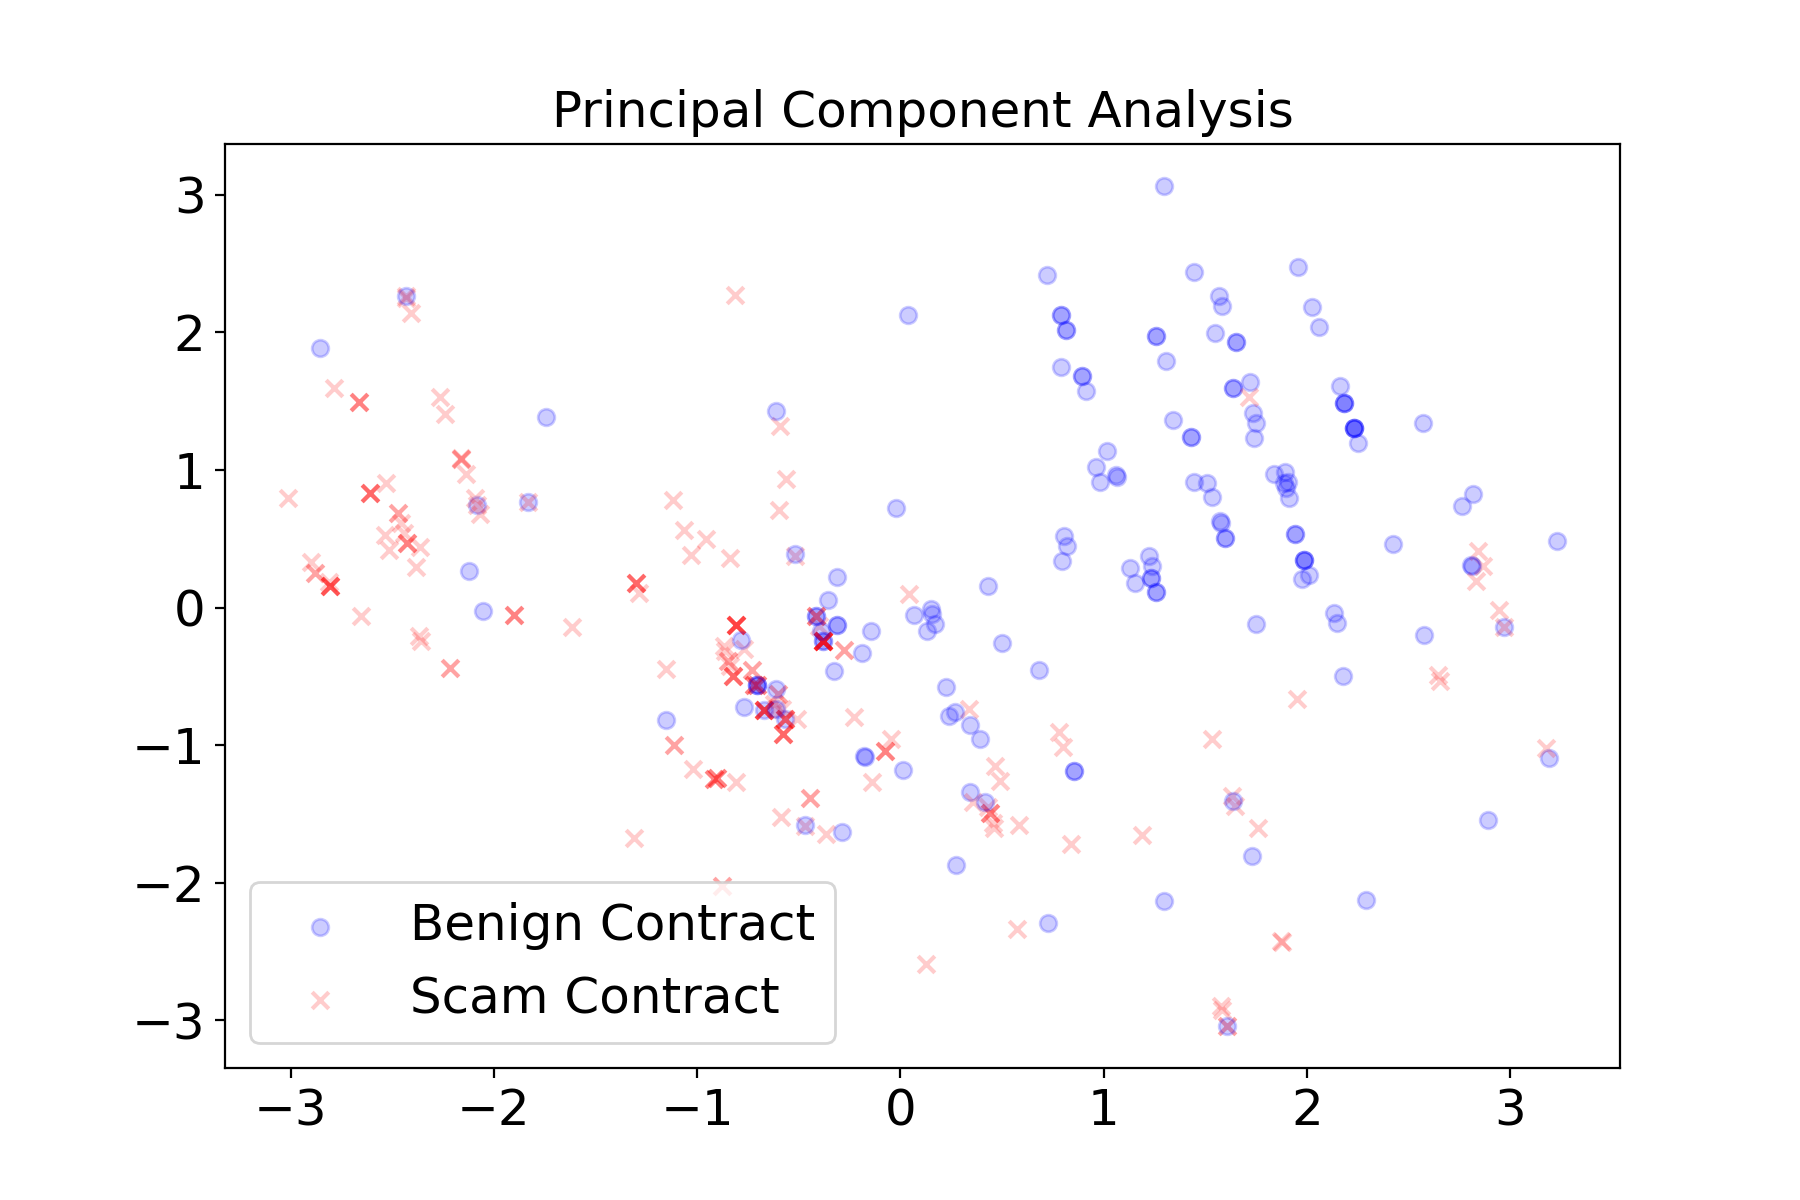

In [27]:

def dodge_points(points, component_index, offset):
    """Dodge every point by a multiplicative offset (multiplier is based on frequency of appearance)

    Args:
        points (array-like (2D)): Array containing the points
        component_index (int): Index / column on which the offset will be applied 
        offset (float): Offset amount. Effective offset for each point is `index of appearance` * offset

    Returns:
        array-like (2D): Dodged points
    """

    # Extract uniques points so we can map an offset for each
    uniques, inv, counts = np.unique(
        points, return_inverse=True, return_counts=True, axis=0
    )

    for i, num_identical in enumerate(counts):
        # Prepare dodge values
        dodge_values = np.array([offset * i for i in range(num_identical)])
        # Find where the dodge values must be applied, in order
        points_loc = np.where(inv == i)[0]
        #Apply the dodge values
        points[points_loc, component_index] += dodge_values

    return points


from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_test)
pca_2d = pca.transform(X_test)

# pca_2d = dodge_points(pca_2d, 0, 0.02)
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize


fig, ax = plt.subplots(figsize =(9, 6))

for i in range(0, pca_2d.shape[0]):
    if testset_annotations[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',alpha=0.2, marker='o')
    else:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',alpha=0.2, marker='x')

plt.scatter(None,None,c='b',alpha=0.2, marker='o', label="Benign Contract")
plt.scatter(None,None,c='r',alpha=0.2, marker='x', label="Scam Contract")
        
plt.title("Principal Component Analysis")
plt.legend()
plt.savefig("pca_test.pdf")
plt.show()

<IPython.core.display.Javascript object>


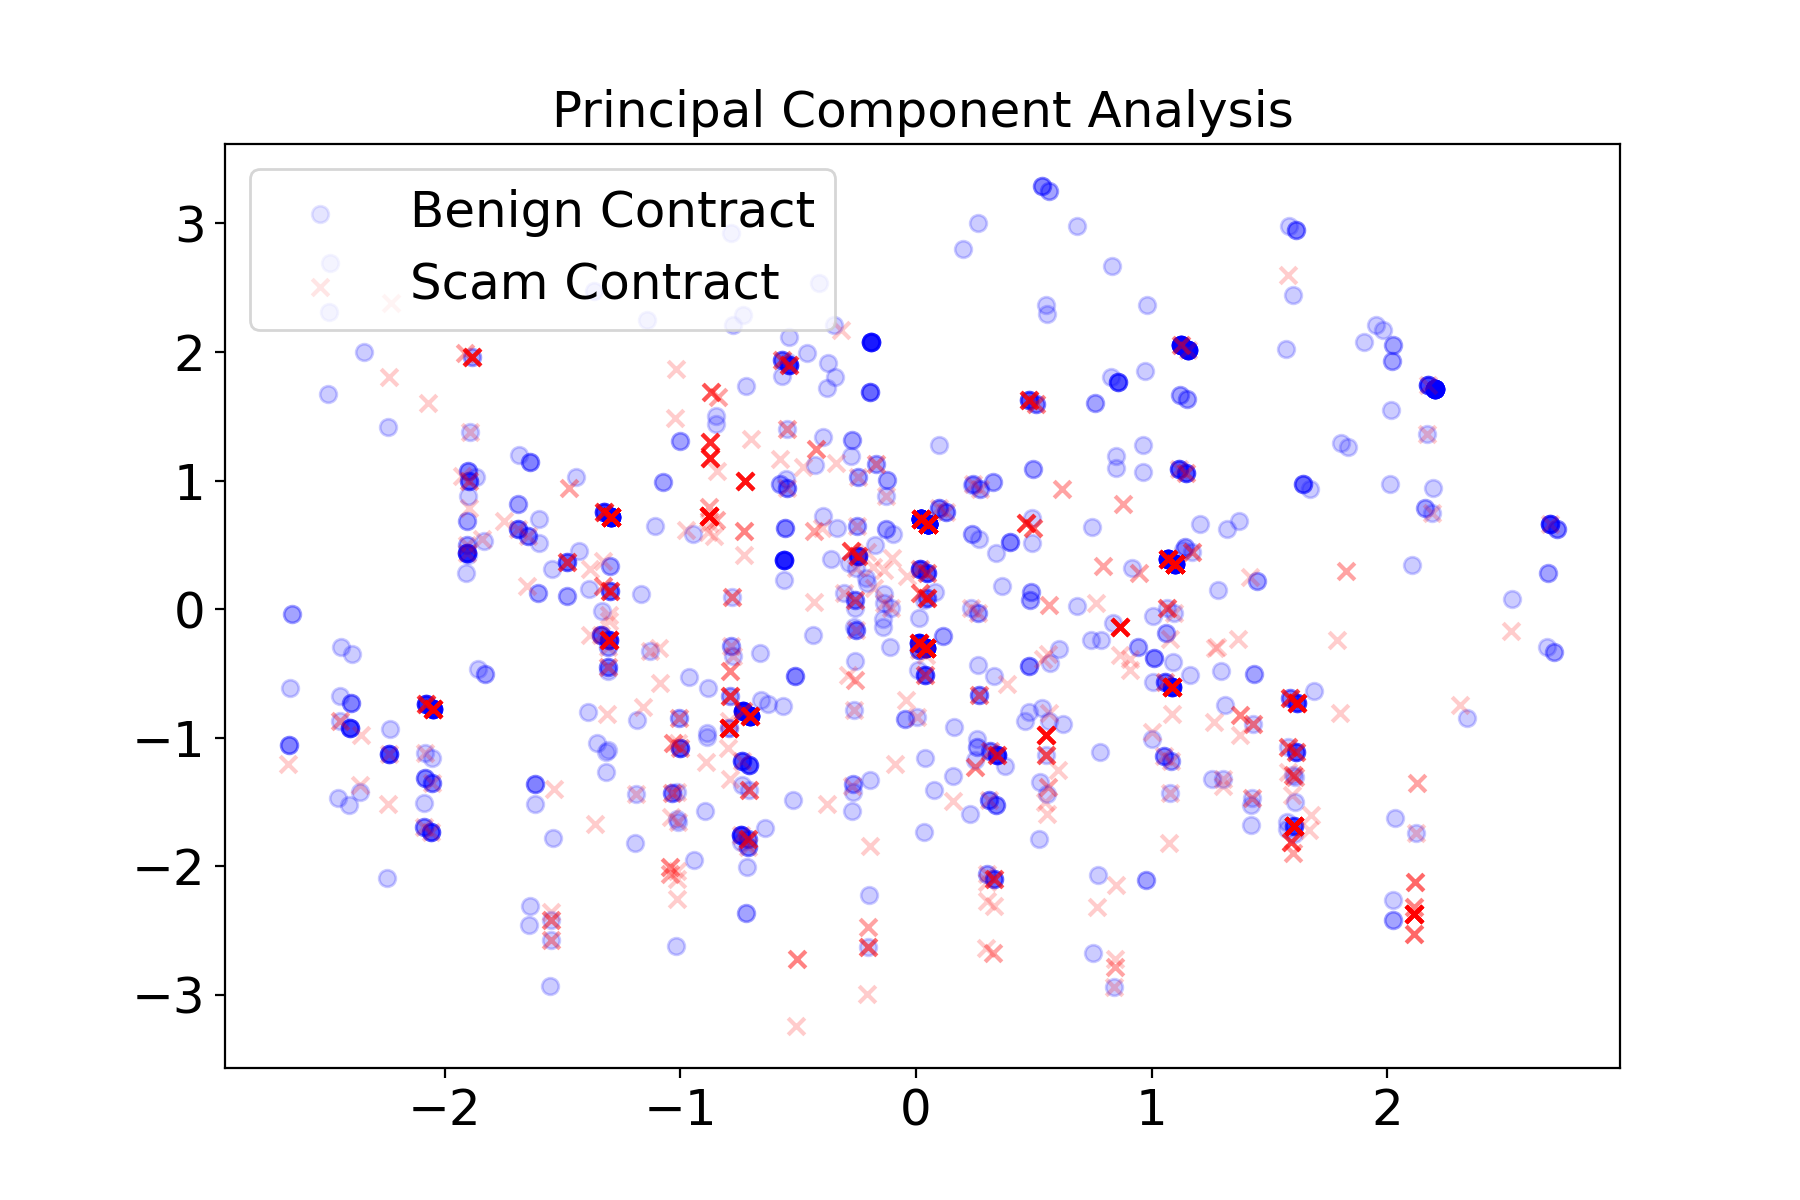

In [8]:

def dodge_points(points, component_index, offset):
    """Dodge every point by a multiplicative offset (multiplier is based on frequency of appearance)

    Args:
        points (array-like (2D)): Array containing the points
        component_index (int): Index / column on which the offset will be applied 
        offset (float): Offset amount. Effective offset for each point is `index of appearance` * offset

    Returns:
        array-like (2D): Dodged points
    """

    # Extract uniques points so we can map an offset for each
    uniques, inv, counts = np.unique(
        points, return_inverse=True, return_counts=True, axis=0
    )

    for i, num_identical in enumerate(counts):
        # Prepare dodge values
        dodge_values = np.array([offset * i for i in range(num_identical)])
        # Find where the dodge values must be applied, in order
        points_loc = np.where(inv == i)[0]
        #Apply the dodge values
        points[points_loc, component_index] += dodge_values

    return points


from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)

# pca_2d = dodge_points(pca_2d, 0, 0.02)
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize


fig, ax = plt.subplots(figsize =(9, 6))

for i in range(0, pca_2d.shape[0]):
    if trainset_annotations[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',alpha=0.2, marker='o')
    else:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',alpha=0.2, marker='x')

plt.scatter(None,None,c='b',alpha=0.1, marker='o', label="Benign Contract")
plt.scatter(None,None,c='r',alpha=0.1, marker='x', label="Scam Contract")
        
plt.title("Principal Component Analysis")
plt.legend()
plt.savefig("pca_training.pdf")
plt.show()

[15:53:49] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators", "normalize_type", "rate_drop", "sample_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


342
[132  21  68 121]
0.18621588753718596
73.98 %
73.11 %


<IPython.core.display.Javascript object>


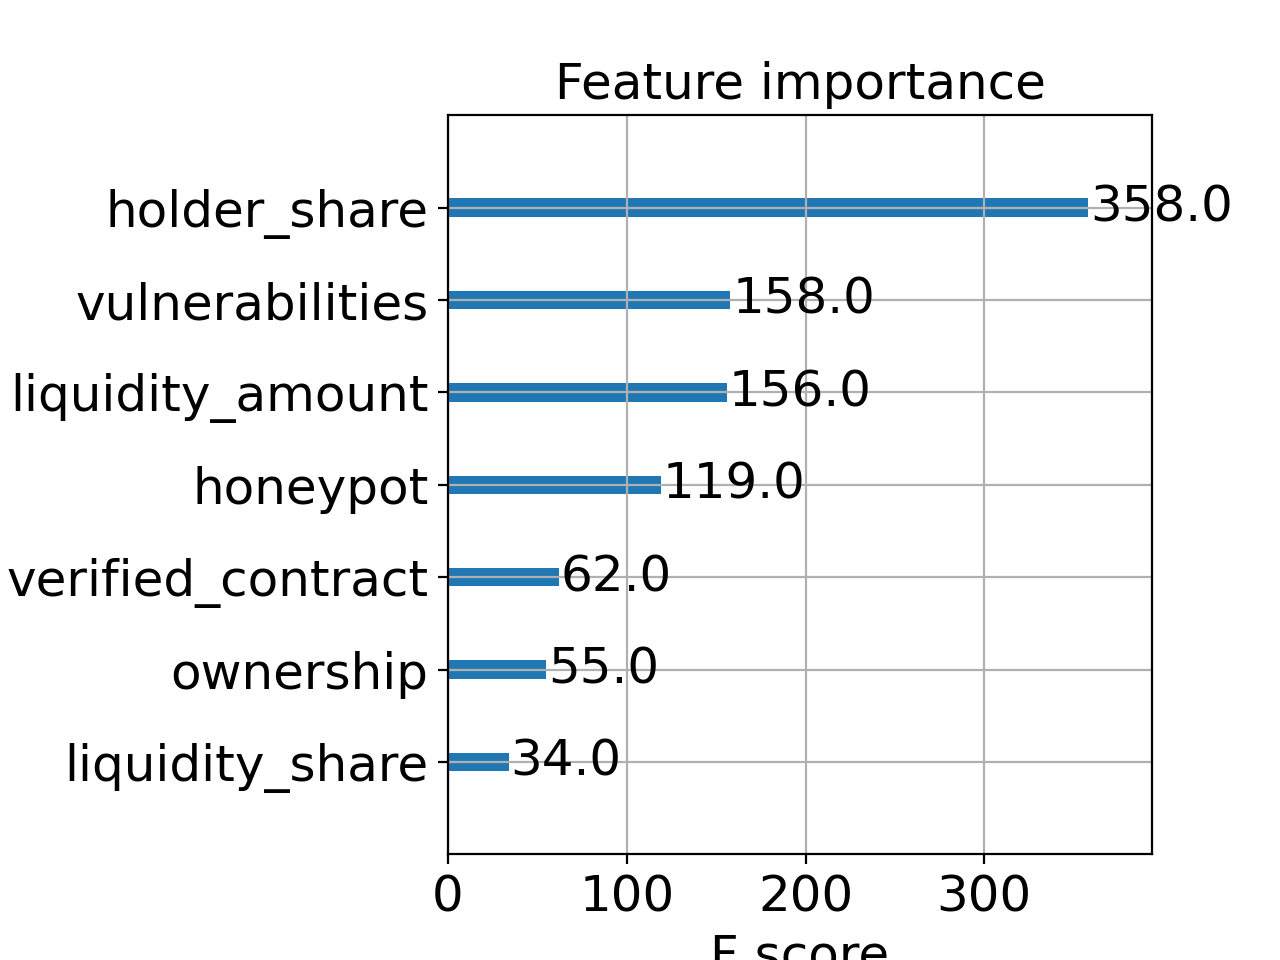

In [30]:
import xgboost as xgb

orig_feature_names = ['liquidity_share','holder_share','liquidity_amount', 
                      'honeypot', 'ownership','verified_contract','vulnerabilities']

d_train = xgb.DMatrix(X_train, trainset_annotations, feature_names=orig_feature_names)

d_test = xgb.DMatrix(X_test, testset_annotations, feature_names=orig_feature_names)
# print(X_test)

params_1 = {
    'booster': 'gbtree',
    'max_depth': 500, 
    'learning_rate': 0.1,
    'sample_type': 'uniform', # uniform, weighted
    'normalize_type': 'tree',
    'objective': 'binary:logistic',# binary:logistic binary:hinge
    'rate_drop': 0.1,
    'n_estimators': 70
}

xgb_clf = xgb.train(params_1, d_train)


preds = xgb_clf.predict(d_train)

preds2 = xgb_clf.predict(d_test)


#for i in range(len(preds)):
    # print(preds[i])
#     print(testset_annotations[i])
    # print(trainset_annotations[i])



predictions = [round(value) for value in preds2]
print(len(predictions))
print(metrics.confusion_matrix(testset_annotations, predictions).ravel())
print(metrics.mean_squared_error(preds2, testset_annotations))
print(np.round(metrics.accuracy_score(testset_annotations, predictions)*100, 2), '%')
print(np.round(metrics.f1_score(testset_annotations, predictions)*100, 2), '%')

joblib.dump(scaler, 'evaluation/xgb_data_scaler.joblib')
joblib.dump(xgb_clf, 'evaluation/xgb_classifier.joblib')



xgb.plot_importance(xgb_clf)
plt.subplots_adjust(left=0.35)

plt.show()

# result['liquidity_share_result'], result['holder_share_result'], result['liquidity_amount_result'],
# result['honeypot_result'], result['ownership_result'], result['verified_contract_result'], 
# result['vulnerabilities_result']

[727 273 243 757]
0.1805712384542709
74.2 %
74.58 %


<IPython.core.display.Javascript object>


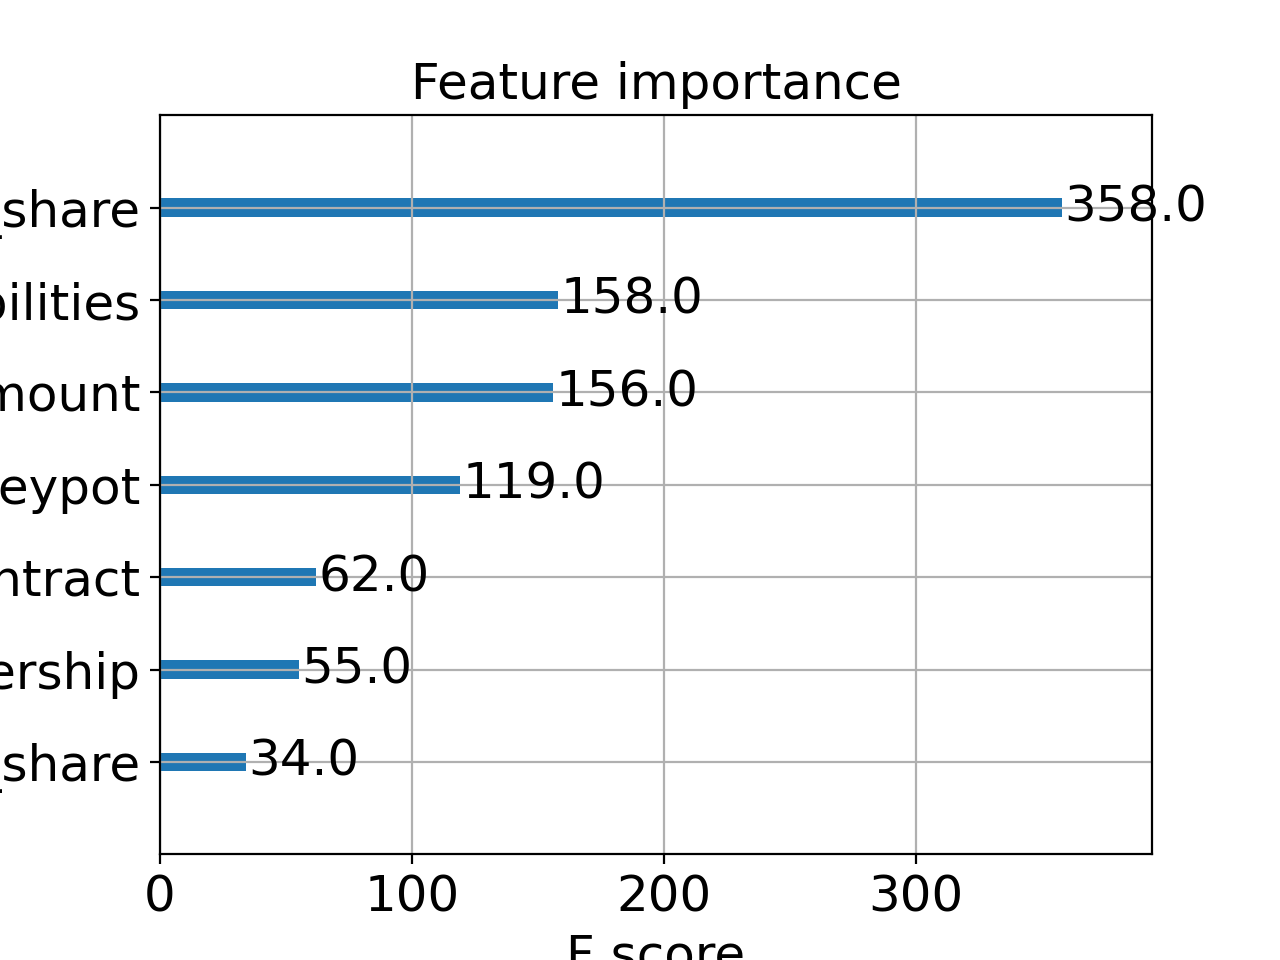

(1, 0.6551614, 0)
(0, 0.40550354, 0)
(0, 0.4550809, 0)
(0, 0.40913916, 0)
(0, 0.2559846, 0)
(0, 0.23978117, 0)
(1, 0.64552504, 0)
(1, 0.53294086, 0)
(0, 0.42335215, 0)
(0, 0.48725447, 0)
(0, 0.33070514, 0)
(0, 0.4058485, 0)
(1, 0.64145374, 0)
(0, 0.31418866, 0)
(0, 0.2402972, 0)
(0, 0.2559846, 0)
(0, 0.49686715, 0)
(0, 0.33484164, 0)
(1, 0.62767774, 0)
(0, 0.45389947, 0)
(0, 0.47105396, 0)
(1, 0.53294086, 0)
(0, 0.3599685, 0)
(0, 0.33155268, 0)
(1, 0.507613, 0)
(0, 0.3846478, 0)
(0, 0.39781594, 0)
(1, 0.53294086, 0)
(0, 0.23030955, 0)
(0, 0.24388342, 0)
(0, 0.2714877, 0)
(0, 0.45165926, 0)
(0, 0.37481618, 0)
(1, 0.61609024, 0)
(0, 0.33484164, 0)
(0, 0.23622344, 0)
(1, 0.5761883, 0)
(0, 0.20969698, 0)
(1, 0.53294086, 0)
(0, 0.27151015, 0)
(0, 0.40550354, 0)
(0, 0.4550809, 0)
(1, 0.5761883, 0)
(0, 0.20969698, 0)
(1, 0.5761883, 0)
(1, 0.5031528, 0)
(0, 0.3026077, 0)
(0, 0.25751773, 0)
(0, 0.23622344, 0)
(1, 0.5761883, 0)
(1, 0.6163456, 0)
(1, 0.6163456, 0)
(1, 0.61609024, 0)
(0, 0.3275805

In [31]:
preds_train = xgb_clf.predict(d_train)

predictions = [round(value) for value in preds_train]

print(metrics.confusion_matrix(trainset_annotations, predictions).ravel())
print(metrics.mean_squared_error(preds_train, trainset_annotations))
print(np.round(metrics.accuracy_score(trainset_annotations, predictions)*100, 2), '%')
print(np.round(metrics.f1_score(trainset_annotations, predictions)*100, 2), '%')

xgb.plot_importance(xgb_clf)

plt.show()

for i in range(len(predictions)):
    print((predictions[i], preds_train[i], trainset_annotations[i]))


using 20% of training set to verify f1 score


In [22]:
x_train, x_val, y_train, y_val = train_test_split(X_train, trainset_annotations, train_size=1500)

d_train = xgb.DMatrix(x_train, y_train)

d_test = xgb.DMatrix(x_val, y_val)

params_1 = {
    'booster': 'gbtree',
    'max_depth': 500, 
    'learning_rate': 0.1,
    'sample_type': 'uniform', # uniform, weighted
    'normalize_type': 'tree',
    'objective': 'binary:logistic',# binary:logistic binary:hinge
    'rate_drop': 0.1,
    'n_estimators': 70
}

xgb_clf = xgb.train(params_1, d_train)



preds = xgb_clf.predict(d_test)

predictions = [round(value) for value in preds]

print(metrics.confusion_matrix(y_val, predictions).ravel())
print(metrics.mean_squared_error(preds, y_val))

print(np.round(metrics.accuracy_score(y_val, predictions)*100, 2), '%')
print(np.round(metrics.f1_score(y_val, predictions)*100, 2), '%')


preds_train = xgb_clf.predict(d_train)

predictions = [round(value) for value in preds_train]

print(metrics.confusion_matrix(y_train, predictions).ravel())
print(metrics.mean_squared_error(preds_train, y_train))
print(np.round(metrics.accuracy_score(y_train, predictions)*100, 2), '%')
print(np.round(metrics.f1_score(y_train, predictions)*100, 2), '%')


[15:51:11] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators", "normalize_type", "rate_drop", "sample_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[167  86  72 175]
0.19981812797197945
68.4 %
68.9 %
[534 213 165 588]
0.18035371438797726
74.8 %
75.68 %


(651, 349, 279, 721)
Accuracy: 0.686
F1 Score: 0.6966183574879227
(127, 26, 66, 123)
Accuracy: 0.7309941520467836
F1 Score: 0.727810650887574
[0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1
 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 1]
[0.4805087  0.33749782 0.51564196 0.65316486 0.5351574  0.70663816
 0.35129689 0.8702931  0.5818401  0.72820574 0.63483862 0.55718067
 0.4253192  0.49319857 0.6553

<IPython.core.display.Javascript object>


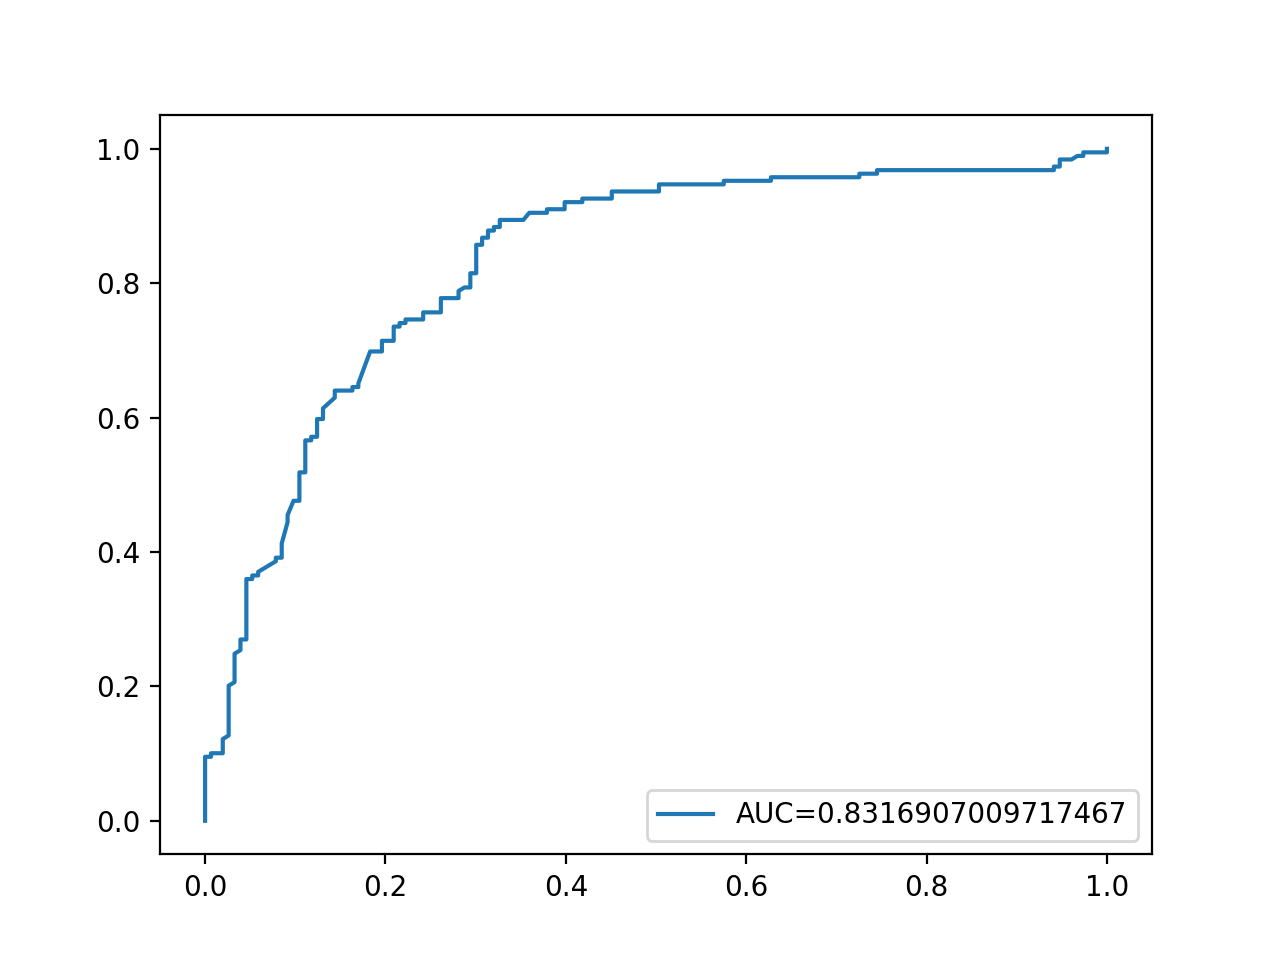

In [61]:
from sklearn.linear_model import LogisticRegression

log_regression = LogisticRegression()

log_regression.fit(X_train,trainset_annotations)


y_pred_train = log_regression.predict(X_train)

tn, fp, fn, tp = metrics.confusion_matrix(trainset_annotations, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(trainset_annotations, y_pred_train))
print("F1 Score:",metrics.f1_score(trainset_annotations, y_pred_train))


y_pred = log_regression.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(testset_annotations, y_pred).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(testset_annotations, y_pred))
print("F1 Score:",metrics.f1_score(testset_annotations, y_pred))

# joblib.dump(log_regression, 'evaluation/log_regression_classifier.joblib')

%matplotlib notebook

print(y_pred)
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
print(y_pred_proba)
fpr, tpr, _ = metrics.roc_curve(testset_annotations,  y_pred_proba)
auc = metrics.roc_auc_score(testset_annotations, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# x_scam = np.sort(pdf_scam_data)
# y_scam = 1. * np.arange(len(pdf_scam_data)) / (len(pdf_scam_data) - 1)

# x_benign = np.sort(pdf_benign_data)
# y_benign = 1. * np.arange(len(pdf_benign_data)) / (len(pdf_benign_data) - 1)
# plt.plot(x_scam, y_scam)

# plt.plot(x_benign, y_benign)


[1 1 0 ... 1 1 0]
[0.61165071 0.7363587  0.4715459  ... 0.61801338 0.74577103 0.38514136]


<IPython.core.display.Javascript object>


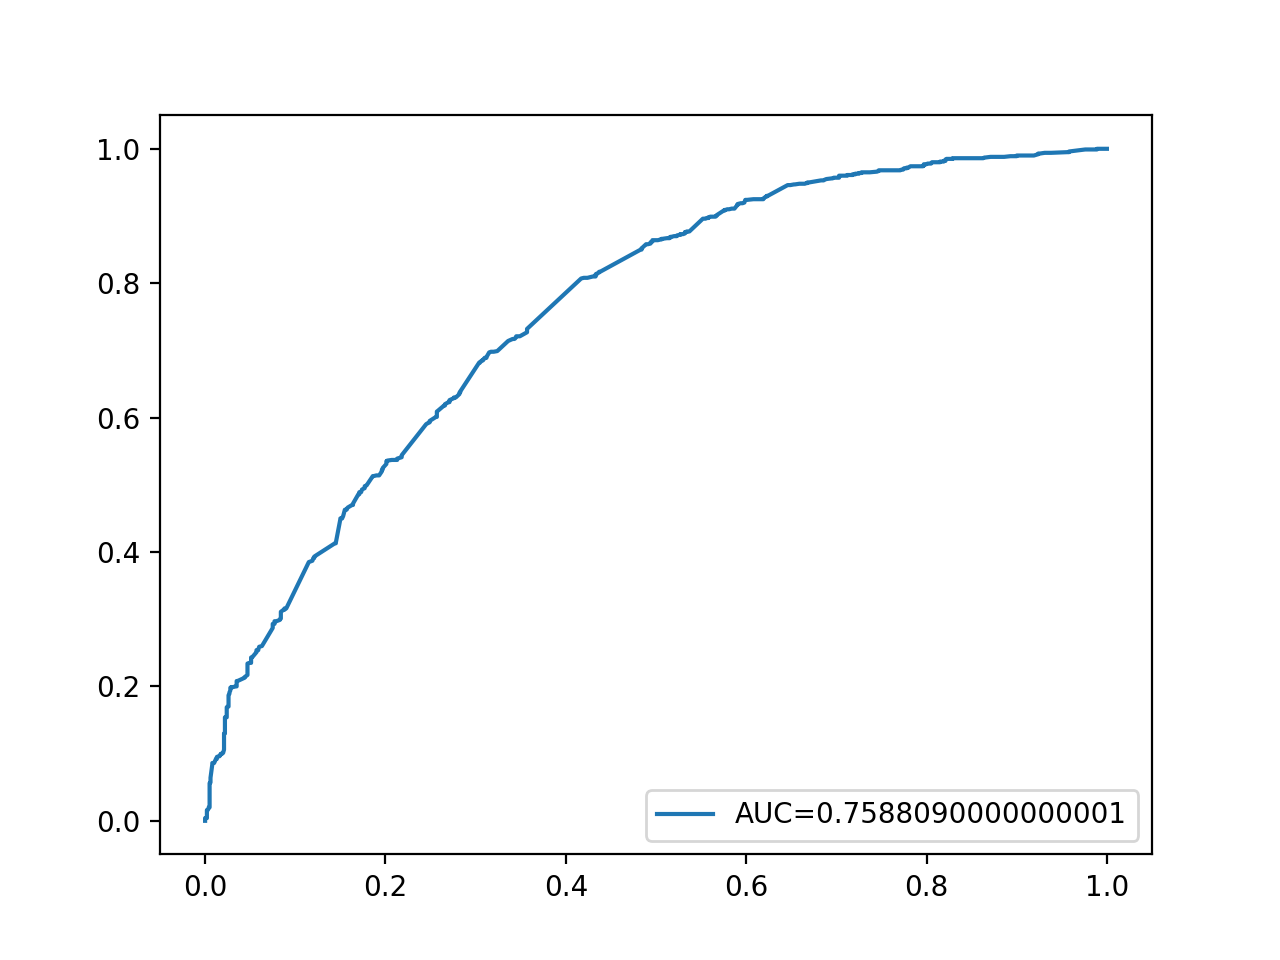

In [62]:

%matplotlib notebook

print(y_pred_train)
y_pred_train_proba = log_regression.predict_proba(X_train)[::,1]
print(y_pred_train_proba)
fpr, tpr, _ = metrics.roc_curve(trainset_annotations,  y_pred_train_proba)
auc = metrics.roc_auc_score(trainset_annotations, y_pred_train_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()